In [1]:
from keras.datasets import mnist

import numpy as np

import module
import optimizer 
import loss 
import datahandler

from matplotlib import pyplot as plt
import numpy as np
from numpy import shape

from tqdm import tqdm


2025-01-09 12:50:03.590222: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-09 12:50:03.595298: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-09 12:50:03.611121: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736419803.633255   11672 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736419803.639063   11672 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-09 12:50:03.661201: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:

def prepocess_data(x_train, y_train, x_test, y_test, training_size, test_size):
    x_train = x_train.reshape(x_train.shape[0], 28 * 28, 1)
    x_test = x_test.reshape(x_test.shape[0], 28 * 28, 1)

    x_train = x_train.T
    x_test = x_test.T

    x_train = x_train[:, :, 0:training_size]
    x_test = x_test[:, :, 0:test_size]

    x_train = x_train[0, :, 0:training_size]
    x_test = x_test[0, :, 0:test_size]

    y_test = y_test[:test_size]
    y_train = y_train[:training_size]
   
    
    y_tr = np.zeros((10, training_size))
    y_ts = np.zeros((10, test_size))
    
    y_tr[0, :] = y_train
    y_ts[0, :] = y_test

    y_test = y_ts
    y_train = y_tr
    for i in range(training_size):
        n_tmp = int(y_train[0, i])

        
        y_train[:, i] = np.zeros(10)
        y_train[n_tmp, i] = 1
    print(y_train)

    for i in range(test_size):
        n_tmp = int(y_test[0, i])

        y_test[:, i] = np.zeros(10)
        y_test[n_tmp, i] = 1
    


    x_test, y_test = reshuffle(x_test, y_test)
    x_train, y_train = reshuffle(x_train, y_train)

    return (x_train, y_train, x_test, y_test)


def reshuffle(X, Y):
    NData = len(X[0, :])
    perm_indices = np.arange(NData)
    np.random.shuffle(perm_indices)
    X = X[:, perm_indices]
    Y = Y[:, perm_indices]
    return X, Y

def flatten_input(x):
    x = x.reshape(x.shape[0], 28 * 28, 1)
    """
    TODO figure this out
    """

    x = x.astype("float32") / 255
    return x



In [3]:

# load MNIST using Keras
# Select 2000 training samples and 100 test samples and appropriate preprocess them
training_size = 2000
test_size = 100
(x_train, y_train), (x_test, y_test) = mnist.load_data()

inDimension = 28*28

(x_train, y_train, x_test, y_test) = prepocess_data(x_train, y_train, x_test, y_test, training_size, test_size)

print(np.shape(x_test))
print(np.shape(x_train))
print(np.shape(y_test))
print(np.shape(y_train))


[[0. 1. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(784, 100)
(784, 2000)
(10, 100)
(10, 2000)


In [4]:

nn = module.Module()

nn.appendLayer(inDimension)

for i in range(1):
    nn.appendLayer(100)

nn.appendLayer(10, activation='softmax')
nn.printShape()

nn.setLossFunction(loss.CrossEntropyLoss)


opt = optimizer.SGD(nn, learning_rate=0.1, dynamic_step=True, weight_normalization=True)

loss_vector_sgd = []

wnorm_sgd = []

batch_size = 50
dataHandler = datahandler.DataHandler(x_train, y_train, batch_size=batch_size)

no_epochs = 20
for j in tqdm(range(no_epochs), desc=f"Processing:"):
    
    dataHandler.reset()
    epoch_loss = []
    while dataHandler.hasNext():
        (batchX, batchY) = dataHandler.nextBatch()
        
        nn(batchX, batchY)
        nn.forward()

        nn.calc_loss()

        epoch_loss.append(nn.loss)
        
        wnorm_sgd.append(sum(np.linalg.norm(w) for w in nn.weights))
        nn.backward()

        opt.step()

    loss_vector_sgd.append(np.average(epoch_loss))

Number of Layers: 3
Total Parameters: 79510 (79400 weights and 110 biases)
Size on RAM (approximate) 621.17 Kb
(784 None) x (100 relu) x (10 softmax)
Weight dimensions: (100, 784), (10, 100)


Processing:: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


## print training plots

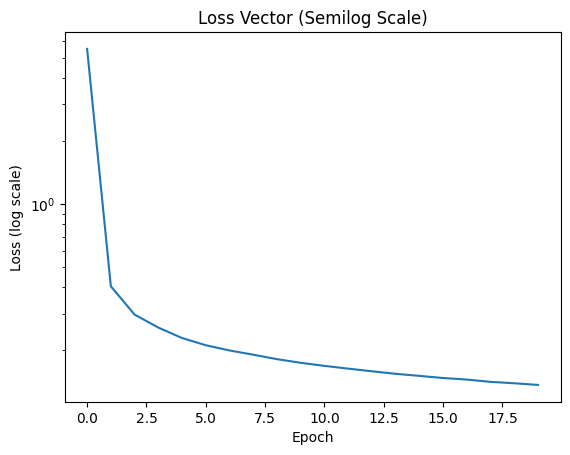

In [5]:

from matplotlib import pyplot as plt
if no_epochs < 2:
    plt.semilogy(loss_vector_sgd, '^-')
    
else:
    plt.semilogy(loss_vector_sgd, '-')
plt.title('Loss Vector (Semilog Scale)')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.show()

# Test for ADAM Optimizer

In [6]:
import optimizer 


nn = module.Module()

nn.appendLayer(inDimension)

for i in range(1):
    nn.appendLayer(100)

nn.appendLayer(10, activation='softmax')
nn.printShape()
nn.setLossFunction(loss.CrossEntropyLoss)

opt = optimizer.ADAM(nn)


loss_vector_adam = []
wnorm_adam = []

dataHandler = datahandler.DataHandler(x_train, y_train, batch_size=batch_size)

no_epochs = 20

for j in tqdm(range(no_epochs), desc=f"Processing:"):
    epoch_loss = []
    dataHandler.reset()
    while dataHandler.hasNext():
        (batchX, batchY) = dataHandler.nextBatch()

        nn(batchX, batchY)
        nn.forward()

        nn.calc_loss()

        epoch_loss.append(nn.loss)
        
        wnorm_adam.append(sum(np.linalg.norm(w) for w in nn.weights))
        nn.backward()

        opt.step()
    loss_vector_adam.append(np.average(epoch_loss))

Number of Layers: 3
Total Parameters: 79510 (79400 weights and 110 biases)
Size on RAM (approximate) 621.17 Kb
(784 None) x (100 relu) x (10 softmax)
Weight dimensions: (100, 784), (10, 100)
ADAM initialized


Processing:: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


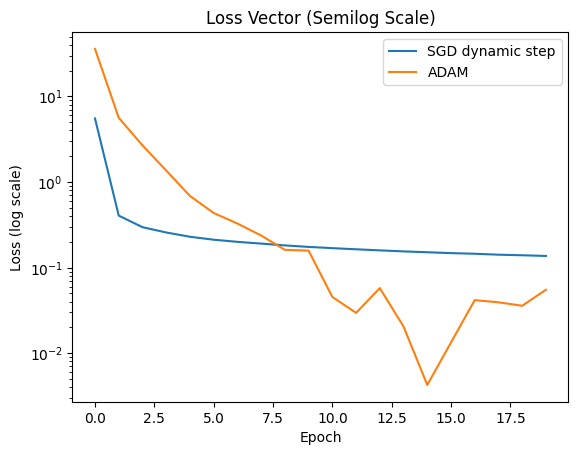

In [7]:
from matplotlib import pyplot as plt

plt.semilogy(loss_vector_sgd, '-')
plt.semilogy(loss_vector_adam, '-')
plt.legend(['SGD dynamic step', 'ADAM'])
plt.title('Loss Vector (Semilog Scale)')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.show()

# Test accuracy for trained model

In [ ]:

## test
dataHandler = datahandler.DataHandler(x_test, y_test, batch_size=1)
error_count = 0
validation_count = 0
while dataHandler.hasNext():
    (batchX, batchY) = dataHandler.nextBatch()
    
    if len(batchX) == 0:
        break

    nn(batchX, batchY)
    nn.forward()
    
    
    try:
        output = np.argmax(nn.output)
        label = np.argmax(batchY)
    except:
        # print('nn,output is ', nn.output)
        break 
    
    error_count += (output != label).astype(int)
    
    validation_count += 1
    
accuracy = (1 - error_count/validation_count)*100
print(f'Evaluation accuracy: {accuracy}%')

Evaluation accuracy: 87.87878787878788%
